<a href="https://colab.research.google.com/github/themalirahul/student-exam-score-analysis/blob/main/student_exam_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Run this if you prefer the upload dialog
from google.colab import files
uploaded = files.upload()   # choose student_exam_scores.csv
for name in uploaded:
    print("Uploaded:", name)

Saving student_exam_scores.csv to student_exam_scores.csv
Uploaded: student_exam_scores.csv


In [ ]:
# Install required packages (Colab usually has most installed)
!pip install -q reportlab seaborn matplotlib pandas scikit-learn scipy

# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from reportlab.lib.pagesizes import A4
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image
from reportlab.lib.styles import getSampleStyleSheet
from scipy.stats import linregress
sns.set(style="whitegrid")
%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.2 MB/s eta 0:00:00


In [ ]:
file_path = "student_exam_scores.csv"   # change if your filename is different
df = pd.read_csv(file_path)

print("Rows, Columns:", df.shape)
display(df.head())
print("\nInfo:")
print(df.info())
print("\nSummary stats:")
display(df.describe())

Rows, Columns: (200, 6)


,student_id,hours_studied,sleep_hours,attendance_percent,previous_scores,exam_score
0,S001,8.0,8.8,72.1,45,30.2
1,S002,1.3,8.6,60.7,55,25.0
2,S003,4.0,8.2,73.7,86,35.8
3,S004,3.5,4.8,95.1,66,34.0
4,S005,9.1,6.4,89.8,71,40.3



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   student_id          200 non-null    object 
 1   hours_studied       200 non-null    float64
 2   sleep_hours         200 non-null    float64
 3   attendance_percent  200 non-null    float64
 4   previous_scores     200 non-null    int64  
 5   exam_score          200 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 9.5+ KB
None

Summary stats:


,hours_studied,sleep_hours,attendance_percent,previous_scores,exam_score
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,6.325500,6.622000,74.830000,66.800000,33.955000
std,3.227317,1.497138,14.249905,15.663869,6.789548
min,1.000000,4.000000,50.300000,40.000000,17.100000
25%,3.500000,5.300000,62.200000,54.000000,29.500000
50%,6.150000,6.700000,75.250000,67.500000,34.050000
75%,9.000000,8.025000,87.425000,80.000000,38.750000
max,12.000000,9.000000,100.000000,95.000000,51.300000


In [ ]:
# 3A: missing and duplicates
print("Missing values per column:\n", df.isnull().sum())
print("Duplicate rows:", df.duplicated().sum())

# 3B: clean student_id and types
df['student_id'] = df['student_id'].astype(str).str.strip()
# ensure numeric fields are numeric
num_cols = ['hours_studied','sleep_hours','attendance_percent','previous_scores','exam_score']
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')

# 3C: drop exact duplicate rows (if any)
df = df.drop_duplicates().reset_index(drop=True)

display(df.head())

Missing values per column:
 student_id            0
hours_studied         0
sleep_hours           0
attendance_percent    0
previous_scores       0
exam_score            0
dtype: int64
Duplicate rows: 0


,student_id,hours_studied,sleep_hours,attendance_percent,previous_scores,exam_score
0,S001,8.0,8.8,72.1,45,30.2
1,S002,1.3,8.6,60.7,55,25.0
2,S003,4.0,8.2,73.7,86,35.8
3,S004,3.5,4.8,95.1,66,34.0
4,S005,9.1,6.4,89.8,71,40.3


In [ ]:
numeric = df[num_cols]
Q1 = numeric.quantile(0.25)
Q3 = numeric.quantile(0.75)
IQR = Q3 - Q1

outlier_mask = ((numeric < (Q1 - 1.5 * IQR)) | (numeric > (Q3 + 1.5 * IQR)))
outlier_counts = outlier_mask.sum()
print("Potential outlier counts per numeric column:\n", outlier_counts)

# Add a flag column marking rows with any outlier in numeric columns
df['outlier_flag'] = outlier_mask.any(axis=1)
print("Total rows flagged as having an outlier:", df['outlier_flag'].sum())
# You can inspect them:
display(df[df['outlier_flag']].head())

Potential outlier counts per numeric column:
 hours_studied         0
sleep_hours           0
attendance_percent    0
previous_scores       0
exam_score            0
dtype: int64
Total rows flagged as having an outlier: 0


,student_id,hours_studied,sleep_hours,attendance_percent,previous_scores,exam_score,outlier_flag


In [ ]:
df['high_attendance'] = df['attendance_percent'] > 75
df['prev_score_group'] = pd.qcut(df['previous_scores'], 4, labels=["Low","Medium","High","Very High"])
display(df[['student_id','attendance_percent','high_attendance','previous_scores','prev_score_group']].head())

,student_id,attendance_percent,high_attendance,previous_scores,prev_score_group
0,S001,72.1,False,45,Low
1,S002,60.7,False,55,Medium
2,S003,73.7,False,86,Very High
3,S004,95.1,True,66,Medium
4,S005,89.8,True,71,High


In [ ]:
plot_dir = "plots"
os.makedirs(plot_dir, exist_ok=True)
plots = []

def save_plot(fig, title, filename, width=800, height=600):
    path = os.path.join(plot_dir, filename)
    fig.set_size_inches(width/100, height/100)
    fig.savefig(path, bbox_inches="tight", dpi=150)
    plt.close(fig)
    plots.append((title, path))

# 1. Distribution of Exam Scores
fig, ax = plt.subplots()
sns.histplot(df['exam_score'], kde=True, bins=20, ax=ax)
ax.set_title("Distribution of Exam Scores")
save_plot(fig, "Distribution of Exam Scores", "exam_score_dist.png")

# 2. Distribution of Hours Studied
fig, ax = plt.subplots()
sns.histplot(df['hours_studied'], kde=True, bins=20, ax=ax)
ax.set_title("Distribution of Hours Studied")
save_plot(fig, "Distribution of Hours Studied", "hours_studied_dist.png")

# 3. Scatter: Hours Studied vs Exam Score
fig, ax = plt.subplots()
sns.scatterplot(x="hours_studied", y="exam_score", data=df, ax=ax)
ax.set_title("Hours Studied vs Exam Score")
save_plot(fig, "Hours Studied vs Exam Score", "hours_vs_exam.png")

# 4. Scatter: Sleep Hours vs Exam Score
fig, ax = plt.subplots()
sns.scatterplot(x="sleep_hours", y="exam_score", data=df, ax=ax)
ax.set_title("Sleep Hours vs Exam Score")
save_plot(fig, "Sleep Hours vs Exam Score", "sleep_vs_exam.png")

# 5. Scatter: Attendance vs Exam Score
fig, ax = plt.subplots()
sns.scatterplot(x="attendance_percent", y="exam_score", data=df, ax=ax)
ax.set_title("Attendance vs Exam Score")
save_plot(fig, "Attendance vs Exam Score", "attendance_vs_exam.png")

# 6. Boxplot: Exam Score by High/Low Attendance
fig, ax = plt.subplots()
sns.boxplot(x="high_attendance", y="exam_score", data=df, ax=ax)
ax.set_title("Exam Score by High vs Low Attendance")
save_plot(fig, "Exam Score by High vs Low Attendance", "exam_by_attendance.png")

# 7. Correlation Heatmap
fig, ax = plt.subplots()
sns.heatmap(df[num_cols + ['outlier_flag']].corr(numeric_only=True), annot=True, cmap="coolwarm", ax=ax)
ax.set_title("Correlation Heatmap")
save_plot(fig, "Correlation Heatmap", "correlation_heatmap.png")

# 8. Pairplot (hours, sleep, exam) — seaborn PairGrid returns an object; save separately
pairplot = sns.pairplot(df[['hours_studied','sleep_hours','exam_score']])
pairplot.savefig(os.path.join(plot_dir, "pairplot.png"))
plots.append(("Pairwise Relationships", os.path.join(plot_dir, "pairplot.png")))
plt.close()

# 9. Exam Score by Previous Score Group
fig, ax = plt.subplots()
sns.boxplot(x="prev_score_group", y="exam_score", data=df, ax=ax)
ax.set_title("Exam Score by Previous Score Group")
save_plot(fig, "Exam Score by Previous Score Group", "exam_by_prev_scores.png")

# 10. Regression: Hours Studied vs Exam Score (with regression line)
fig, ax = plt.subplots()
sns.regplot(x="hours_studied", y="exam_score", data=df, ax=ax, line_kws={"color":"red"})
ax.set_title("Regression: Hours Studied vs Exam Score")
save_plot(fig, "Regression: Hours Studied vs Exam Score", "regression_hours_vs_exam.png")

print("Saved plots:", [p for _, p in plots])

Saved plots: ['plots/exam_score_dist.png', 'plots/hours_studied_dist.png', 'plots/hours_vs_exam.png', 'plots/sleep_vs_exam.png', 'plots/attendance_vs_exam.png', 'plots/exam_by_attendance.png', 'plots/correlation_heatmap.png', 'plots/pairplot.png', 'plots/exam_by_prev_scores.png', 'plots/regression_hours_vs_exam.png']


In [ ]:
insights = []

# 1. Basic distribution
insights.append(f"1) Exam score mean = {df['exam_score'].mean():.2f}, median = {df['exam_score'].median():.2f}.")

# 2. Study hours distribution
insights.append(f"2) Median study hours = {df['hours_studied'].median():.2f}; many students study < 5 hours (count = {(df['hours_studied']<5).sum()}).")

# 3. Correlations
corr_with_exam = df[num_cols].corr()['exam_score'].sort_values(ascending=False)
insights.append(f"3) Top positive correlations with exam_score: {corr_with_exam.drop('exam_score').round(2).to_dict()}.")

# 4. Regression stats (hours vs exam)
slope, intercept, r_value, p_value, stderr = linregress(df['hours_studied'], df['exam_score'])
insights.append(f"4) Regression (exam_score ~ hours_studied): slope={slope:.2f}, R²={r_value**2:.2f}, p={p_value:.3g}.")

# 5. Sleep effect (basic)
sleep_corr = df['sleep_hours'].corr(df['exam_score'])
insights.append(f"5) Sleep_hours correlation with exam_score = {sleep_corr:.2f} (weak).")

# 6. Attendance effect
high_att_mean = df[df['high_attendance']==True]['exam_score'].mean()
low_att_mean = df[df['high_attendance']==False]['exam_score'].mean()
insights.append(f"6) Mean exam_score for high attendance (>75%) = {high_att_mean:.2f} vs low attendance = {low_att_mean:.2f}.")

# 7. Previous scores groups
grp = df.groupby('prev_score_group')['exam_score'].mean().round(2).to_dict()
insights.append(f"7) Mean exam_score by previous score group = {grp}.")

# 8. Outliers
insights.append(f"8) Rows flagged as outliers (IQR method) = {int(df['outlier_flag'].sum())}. Consider inspecting them individually.")

# 9. Hours-study vs exam distribution note
insights.append("9) Scatter/Regression shows upward trend: more hours generally → higher exam_score, but with variance.")

# 10. Actionable suggestion
insights.append("10) Actionable: Encourage increased study hours and attendance — both show positive association with exam performance.")

# Print them nicely
for it in insights:
    print(it)

1) Exam score mean = 33.95, median = 34.05.
2) Median study hours = 6.15; many students study < 5 hours (count = 79).
3) Top positive correlations with exam_score: {'hours_studied': 0.78, 'previous_scores': 0.43, 'attendance_percent': 0.23, 'sleep_hours': 0.19}.
4) Regression (exam_score ~ hours_studied): slope=1.63, R²=0.60, p=1.27e-41.
5) Sleep_hours correlation with exam_score = 0.19 (weak).
6) Mean exam_score for high attendance (>75%) = 34.96 vs low attendance = 32.93.
7) Mean exam_score by previous score group = {'Low': 30.14, 'Medium': 32.8, 'High': 35.28, 'Very High': 37.98}.
8) Rows flagged as outliers (IQR method) = 0. Consider inspecting them individually.
9) Scatter/Regression shows upward trend: more hours generally → higher exam_score, but with variance.
10) Actionable: Encourage increased study hours and attendance — both show positive association with exam performance.


/tmp/ipython-input-2259702041.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('prev_score_group')['exam_score'].mean().round(2).to_dict()


In [ ]:
pdf_path = "student_report.pdf"
doc = SimpleDocTemplate(pdf_path, pagesize=A4)
styles = getSampleStyleSheet()
story = []

story.append(Paragraph("Student Exam Score Analysis Report", styles['Title']))
story.append(Spacer(1, 12))
story.append(Paragraph("Key insights", styles['Heading2']))
for item in insights:
    story.append(Paragraph(item, styles['Normal']))
    story.append(Spacer(1,6))

story.append(Spacer(1,12))
story.append(Paragraph("Graphs", styles['Heading2']))

# Add each saved plot
for title, img_path in plots:
    # Some safety: check file exists
    if os.path.exists(img_path):
        story.append(Paragraph(title, styles['Heading3']))
        # scale images to width ~ 450 points (approx 6.25 inches)
        story.append(Image(img_path, width=450, height=300))
        story.append(Spacer(1,12))

doc.build(story)
print("Saved PDF at:", pdf_path)

Saved PDF at: student_report.pdf


In [ ]:
from google.colab import files
files.download("student_report.pdf")   # downloads PDF

# Zip the plots folder then download
!zip -r plots.zip plots
files.download("plots.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: plots/ (stored 0%)
  adding: plots/exam_by_attendance.png (deflated 24%)
  adding: plots/correlation_heatmap.png (deflated 12%)
  adding: plots/pairplot.png (deflated 4%)
  adding: plots/attendance_vs_exam.png (deflated 11%)
  adding: plots/hours_studied_dist.png (deflated 15%)
  adding: plots/hours_vs_exam.png (deflated 11%)
  adding: plots/regression_hours_vs_exam.png (deflated 8%)
  adding: plots/exam_score_dist.png (deflated 10%)
  adding: plots/exam_by_prev_scores.png (deflated 21%)
  adding: plots/sleep_vs_exam.png (deflated 12%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

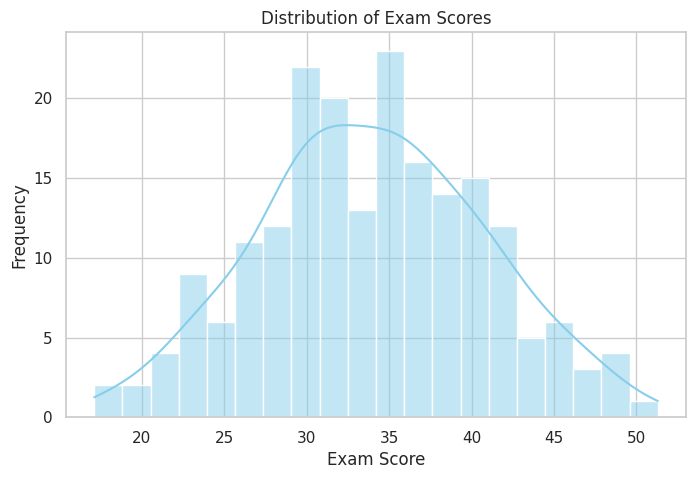

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Distribution of Exam Scores
plt.figure(figsize=(8,5))
sns.histplot(df['exam_score'], bins=20, kde=True, color="skyblue")
plt.title("Distribution of Exam Scores")
plt.xlabel("Exam Score")
plt.ylabel("Frequency")
plt.show()

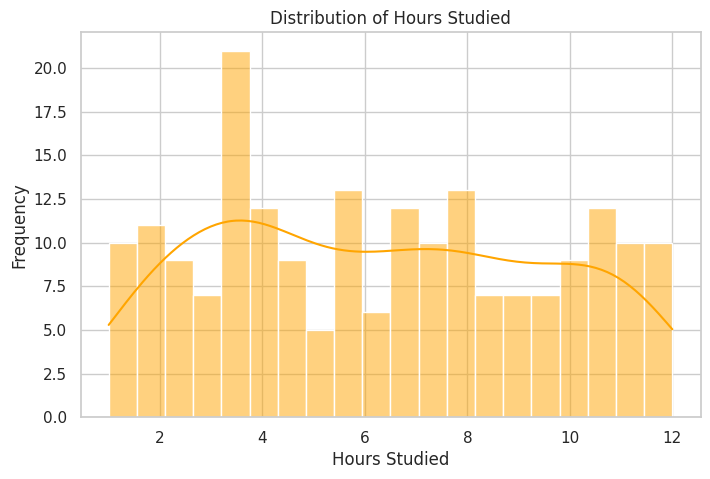

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['hours_studied'], bins=20, kde=True, color="orange")
plt.title("Distribution of Hours Studied")
plt.xlabel("Hours Studied")
plt.ylabel("Frequency")
plt.show()

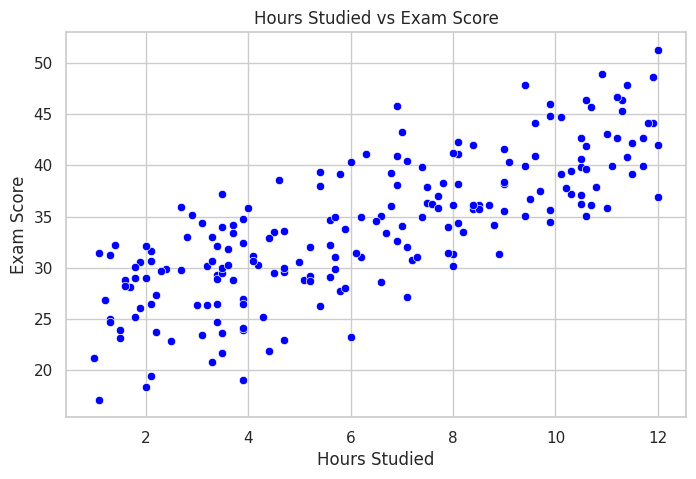

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="hours_studied", y="exam_score", data=df, color="blue")
plt.title("Hours Studied vs Exam Score")
plt.xlabel("Hours Studied")
plt.ylabel("Exam Score")
plt.show()

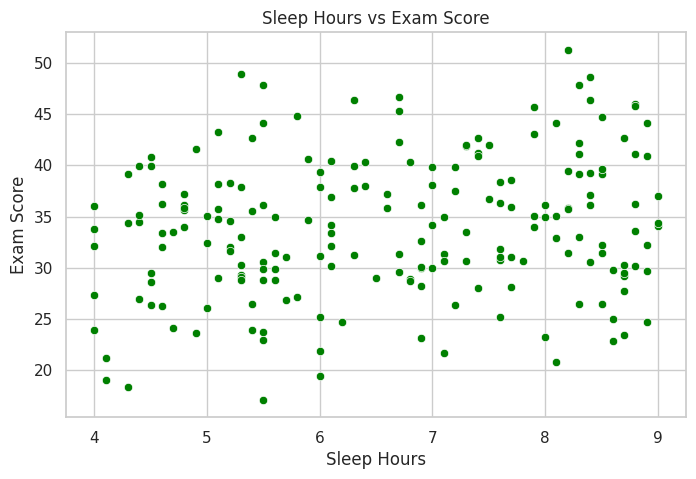

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="sleep_hours", y="exam_score", data=df, color="green")
plt.title("Sleep Hours vs Exam Score")
plt.xlabel("Sleep Hours")
plt.ylabel("Exam Score")
plt.show()

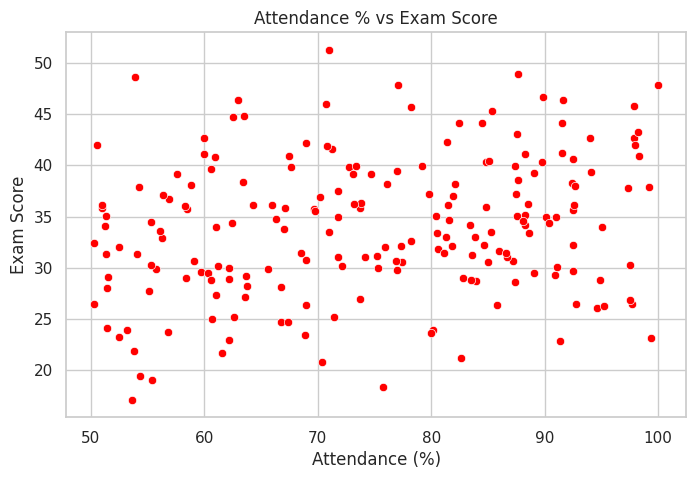

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="attendance_percent", y="exam_score", data=df, color="red")
plt.title("Attendance % vs Exam Score")
plt.xlabel("Attendance (%)")
plt.ylabel("Exam Score")
plt.show()

/tmp/ipython-input-20865544.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="high_attendance", y="exam_score", data=df, palette="Set2")


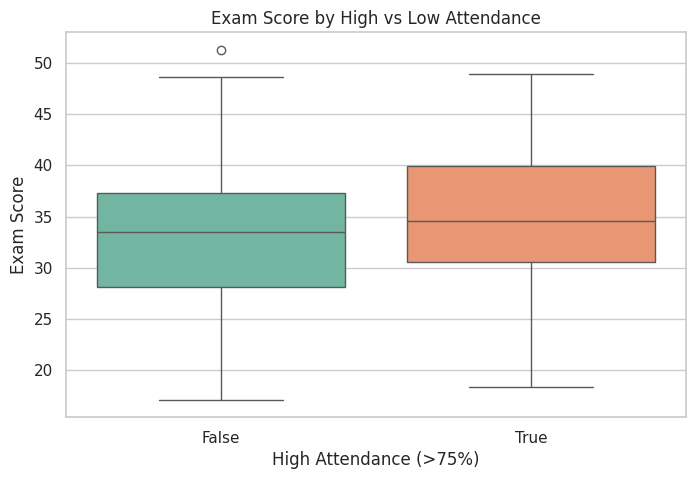

In [ ]:
# Create high/low attendance groups
df['high_attendance'] = df['attendance_percent'] > 75

plt.figure(figsize=(8,5))
sns.boxplot(x="high_attendance", y="exam_score", data=df, palette="Set2")
plt.title("Exam Score by High vs Low Attendance")
plt.xlabel("High Attendance (>75%)")
plt.ylabel("Exam Score")
plt.show()

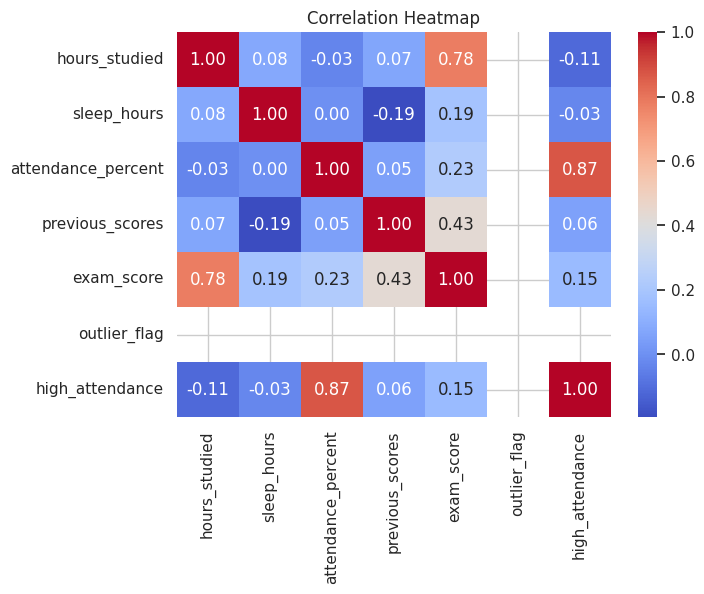

In [ ]:
plt.figure(figsize=(7,5))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

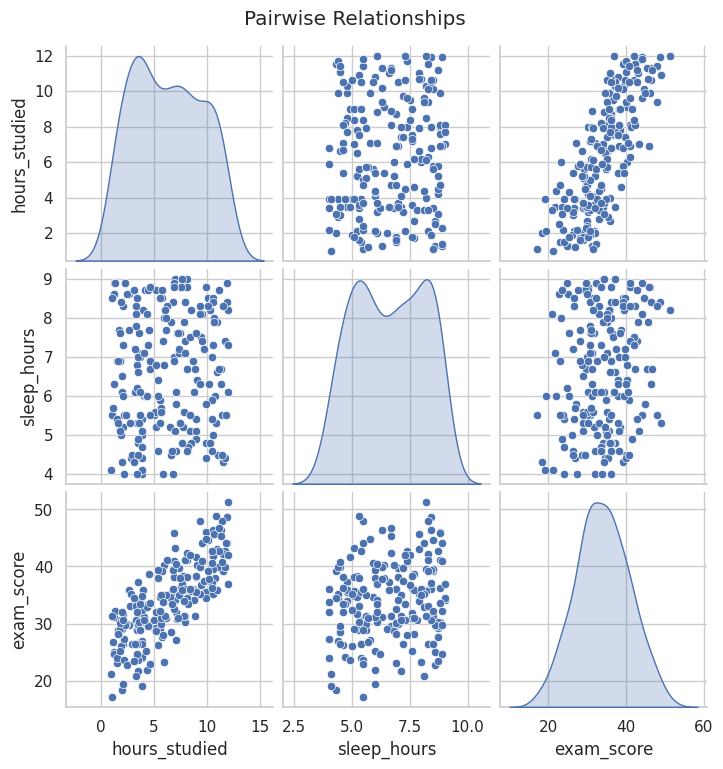

In [ ]:
sns.pairplot(df[['hours_studied', 'sleep_hours', 'exam_score']], diag_kind="kde")
plt.suptitle("Pairwise Relationships", y=1.02)
plt.show()

/tmp/ipython-input-1406037442.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="prev_score_group", y="exam_score", data=df, palette="Set3")


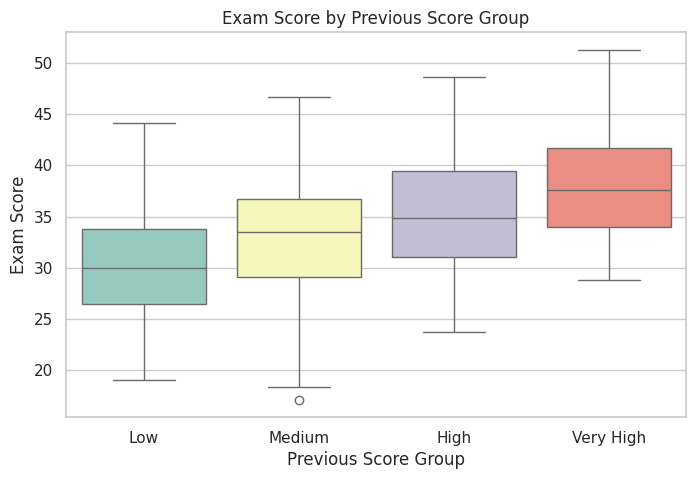

In [ ]:
# Create groups based on previous scores
df['prev_score_group'] = pd.qcut(df['previous_scores'], 4, labels=["Low", "Medium", "High", "Very High"])

plt.figure(figsize=(8,5))
sns.boxplot(x="prev_score_group", y="exam_score", data=df, palette="Set3")
plt.title("Exam Score by Previous Score Group")
plt.xlabel("Previous Score Group")
plt.ylabel("Exam Score")
plt.show()

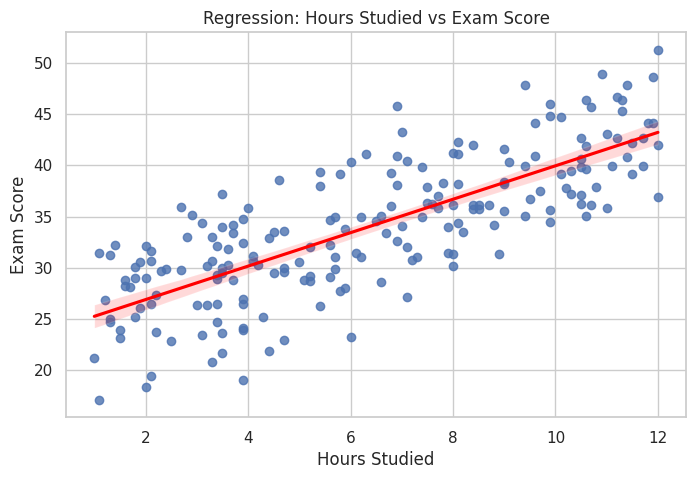

In [ ]:
plt.figure(figsize=(8,5))
sns.regplot(x="hours_studied", y="exam_score", data=df, line_kws={"color": "red"})
plt.title("Regression: Hours Studied vs Exam Score")
plt.xlabel("Hours Studied")
plt.ylabel("Exam Score")
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>